# Dataset Preprocessing

In [1]:
# While Model training
# 1. --- Print model summary (trainable, non-trainable, total parameters) 
# 2. --- while compiling the model, add other metrics like roc_auc score, precision, recall,f1-score,specifity,sensivity,accuracy,loss (training and validation both)
# 3. --- Plot metrics curves VS epochs like mentioned in 2 
# 4. --- Plot confusion matrix like training, validation, test dataset 
# 5. --- Implement early stopping with 100 epochs
# 6. --- records total time (training, testing, validation) and also What GPU you are using it.
# 7. ---- Save the models as well ( .hdf5 format for loading the trained weights)
# 8. ---- keep similar loss functions, optimizers, learning rate, epochs, ...etc

In [2]:
!pip install keras tensorflow

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'

In [5]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
df.shape

(10015, 7)

In [9]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

In [10]:
import os
from glob import glob
# Use glob to get a list of file paths
image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
# Create a dictionary mapping image IDs to file paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


In [12]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

/tmp/ipykernel_23/1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [14]:
df.isna().sum().sum()

0

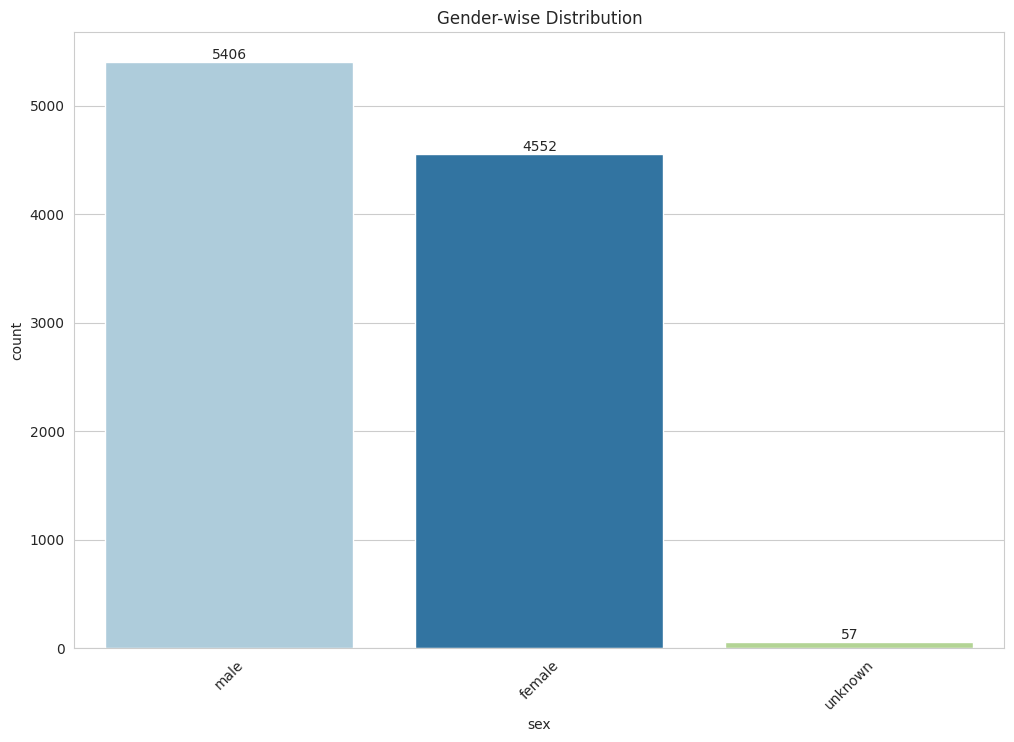

In [15]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

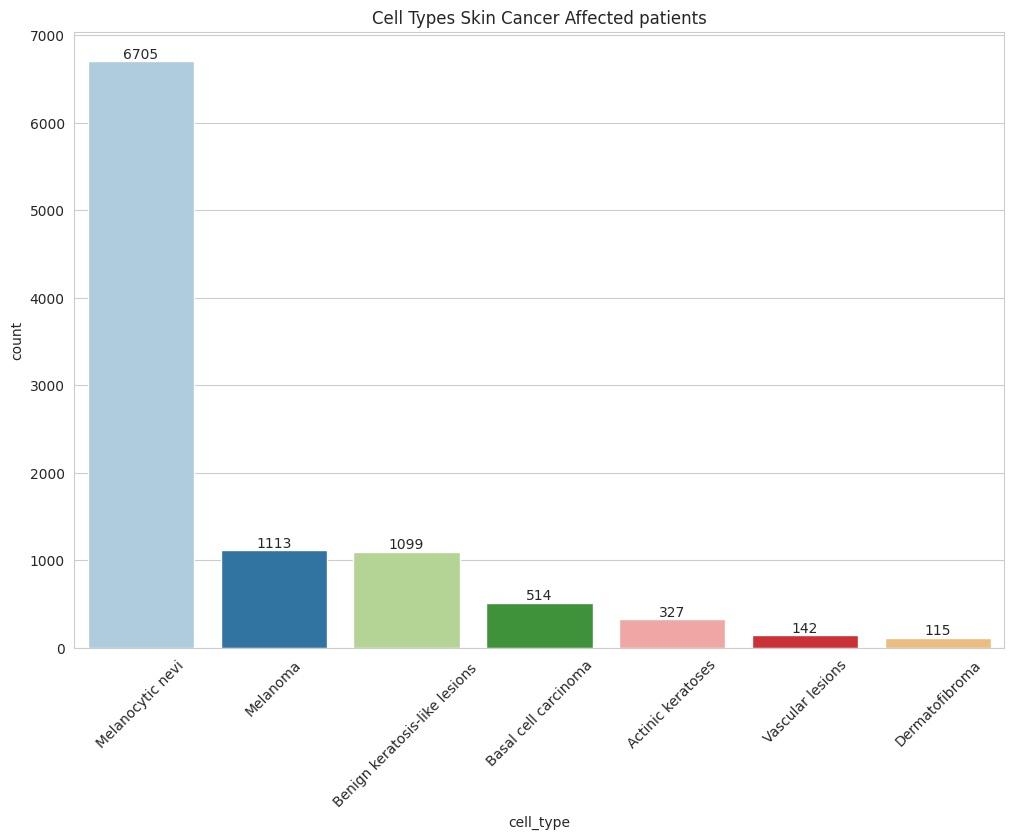

In [16]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

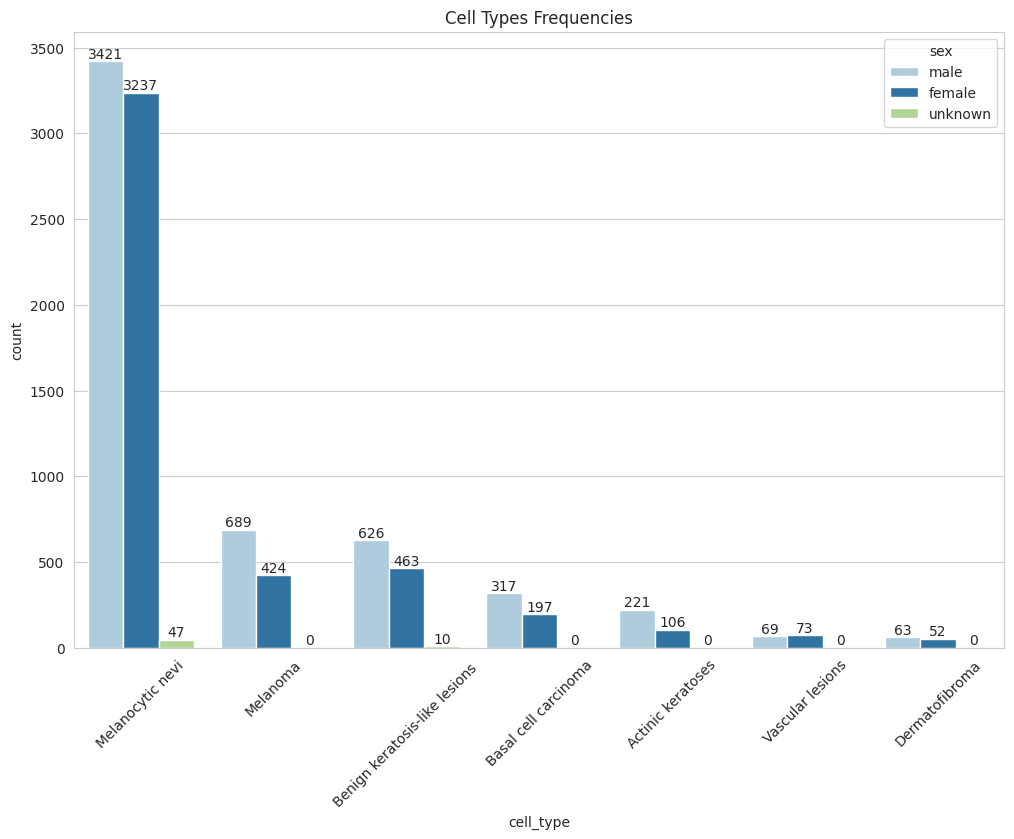

In [17]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

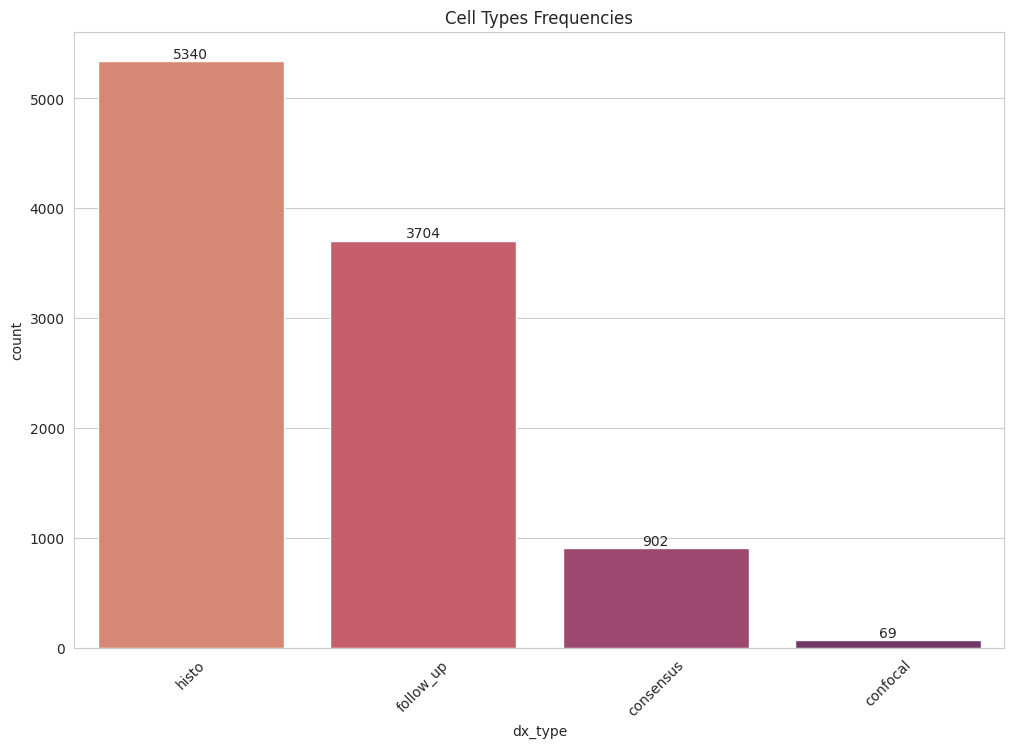

In [18]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

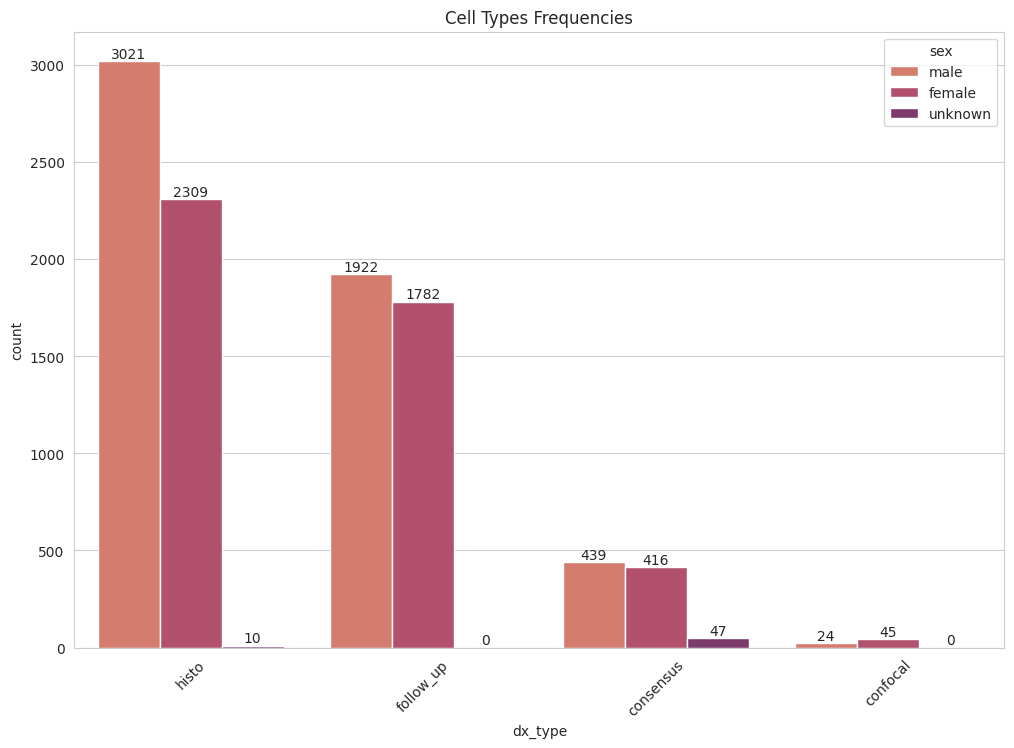

In [19]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


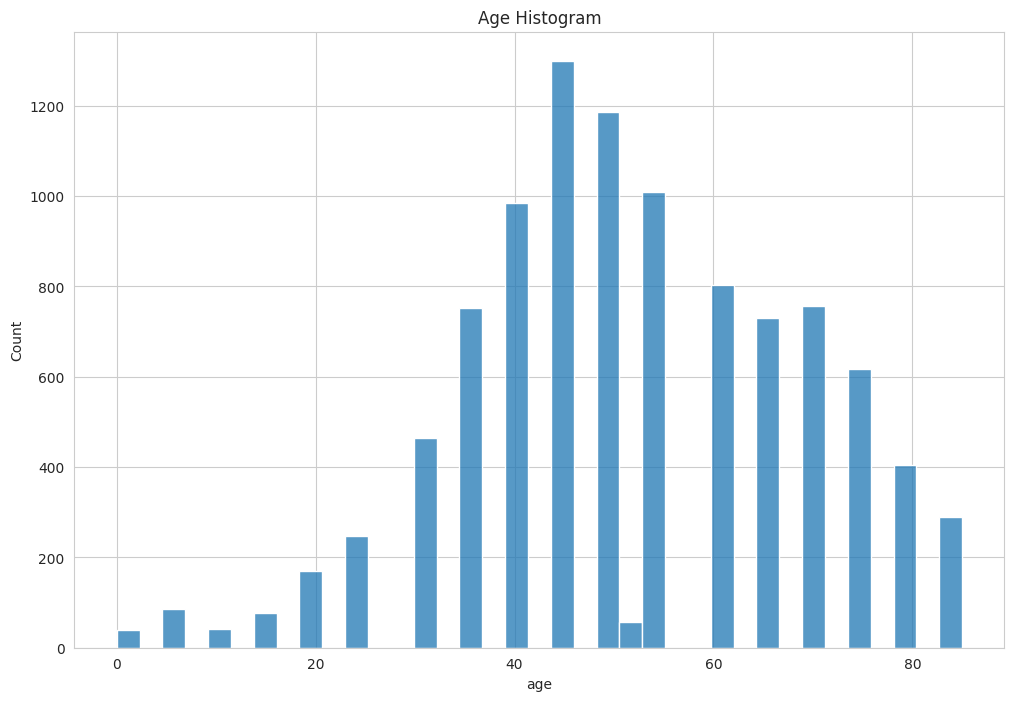

In [20]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

In [21]:
size = (64, 64)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

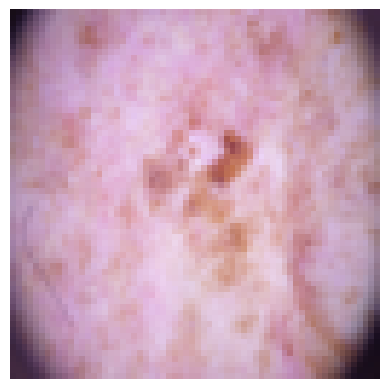

In [22]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off')
plt.show()

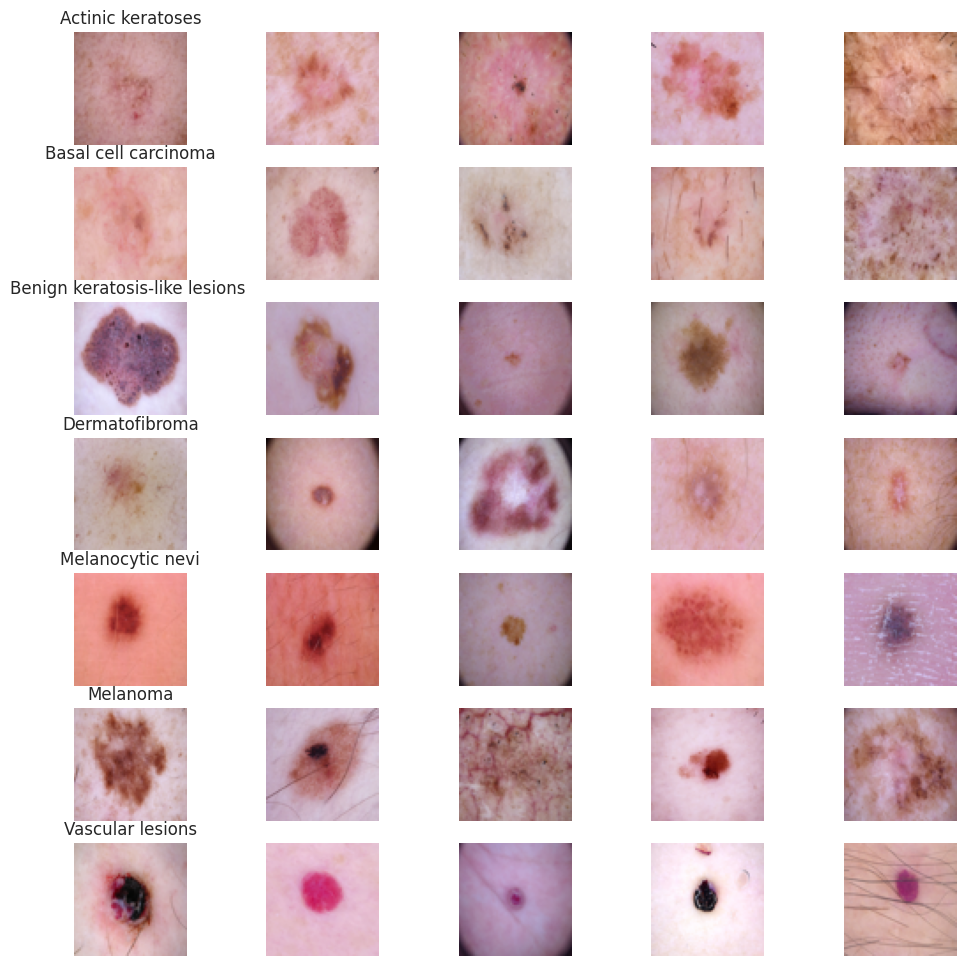

In [23]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [24]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [25]:
def aug_brightness(img_arr):
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)
    return aug_arr

In [26]:
def aug_contrast(img_arr):
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)
    return aug_arr

In [27]:
def aug_flip_left_right(img_arr):
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    return aug_arr

In [28]:
def aug_flip_up_down(img_arr):
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    return aug_arr

In [29]:
def aug_hue(img_arr):
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)
    return aug_arr

In [30]:
def aug_saturation(img_arr):
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)
    return aug_arr

In [31]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [32]:
from IPython.display import clear_output
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))
    new_images = pd.DataFrame({'dx': dx, 'image': new_images})
    return all_indices, new_images

In [33]:
nv_df = df[df['dx'] == 'nv']
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

In [34]:
seed = (4,2)

In [35]:
max_count = 10000
nv_count = (df['dx'] == 'nv').sum()
mel_count = (df['dx'] == 'mel').sum()
bkl_count = (df['dx'] == 'bkl').sum()
bcc_count = (df['dx'] == 'bcc').sum()
akiec_count = (df['dx'] == 'akiec').sum()
vasc_count = (df['dx'] == 'vasc').sum()
df_count = (df['dx'] == 'df').sum()

In [36]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', max_count - df_count)

9888/9885


In [37]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', max_count - vasc_count)

9858/9858


In [38]:
akiec_images = akiec_df['image'] 
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', max_count - akiec_count)

9678/9673


In [39]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', max_count - bcc_count)

9486/9486


In [40]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', max_count - bkl_count)

8904/8901


In [41]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', max_count - mel_count)

8892/8887


In [42]:
nv_images = nv_df['image']
nv_indices, nv_new_images = random_augmentation(nv_images, 'nv', max_count - nv_count)

3300/3295


In [43]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images, nv_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [44]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,mel,10005
1,akiec,10005
2,nv,10005
3,bkl,10003
4,df,10003
5,vasc,10000
6,bcc,10000


In [45]:
aug_df.shape

(70021, 11)

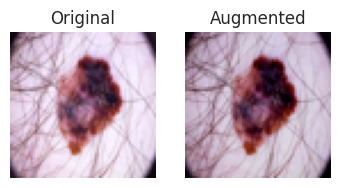

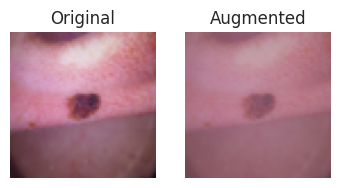

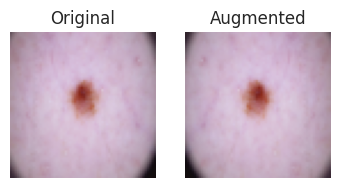

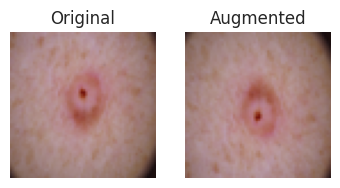

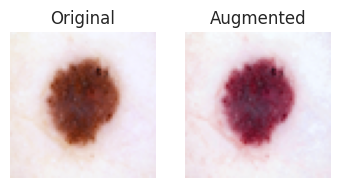

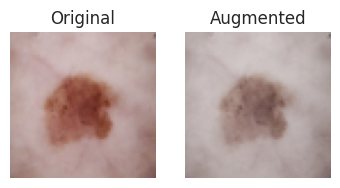

In [46]:
for i in range(12, 18):
    plt.subplot(1, 3, 1)
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')
    plt.show()

In [47]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [48]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, shuffle=True, stratify=y
)

# Model setup

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

In [50]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):  # Accept extra arguments
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [51]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        """
        Initializes the PatchEncoder layer.
        Args:
            num_patches (int): Total number of patches per image.
            projection_dim (int): Dimensionality of the projection space.
        """
        super(PatchEncoder, self).__init__(**kwargs)  # Pass additional arguments to the base class
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)  # Linear projection
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )  # Positional embeddings
    def call(self, patch):
        """
        Encodes the patches by projecting and adding positional embeddings.
        Args:
            patch (tf.Tensor): A batch of patches with shape (batch_size, num_patches, patch_dims).
        Returns:
            tf.Tensor: Encoded patches with shape (batch_size, num_patches, projection_dim).
        """
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # [0, 1, 2, ..., num_patches-1]
        positions = self.position_embedding(positions)  # (num_patches, projection_dim)
        projected_patches = self.projection(patch)  # (batch_size, num_patches, projection_dim)
        encoded = projected_patches + positions  # Broadcasting addition
        return encoded
    def get_config(self):
        """
        Returns the configuration of the layer.
        This enables the layer to be serialized.
        Returns:
            dict: Configuration dictionary.
        """
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units
        })
        return config


In [52]:
def mlp(x, hidden_units, dropout_rate):
    """
    Constructs an MLP with the specified hidden units and dropout rate.
    Args:
        x (tf.Tensor): Input tensor.
        hidden_units (list of int): Number of units in each hidden dense layer.
        dropout_rate (float): Dropout rate for regularization.
    Returns:
        tf.Tensor: Output tensor after passing through the MLP.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)  # relu activation
        x = layers.Dropout(dropout_rate)(x)
    return x


In [53]:
# Hyperparameters
image_size = 64
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
num_heads = 8
transformer_units = [512, 256]
mlp_head_units = [1024, 512]
num_transformer_blocks = 2
num_classes = 7
conv_filters = 256
conv_depth = 2
conv_kernel_size = 5
dropout_rate = 0.1

In [54]:
# Vision Transformer Branch
def create_vit_branch_with_exits(inputs):
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    exits = []
    for i in range(num_transformer_blocks):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, dropout_rate)
        encoded_patches = layers.Add()([x3, x2])
        # Intermediate exit
        intermediate_output = layers.GlobalAveragePooling1D()(encoded_patches)
        exit_output = layers.Dense(num_classes, activation="softmax", name=f"vit_exit_{i+1}")(intermediate_output)
        exits.append(exit_output)
    vit_features = layers.GlobalAveragePooling1D()(encoded_patches)
    final_output = layers.Dense(num_classes, activation="softmax", name="vit_final_output")(vit_features)
    return final_output, vit_features, exits
# ConvMixer Branch
def create_convmixer_branch_with_exits(inputs):
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = layers.Conv2D(conv_filters, kernel_size=patch_size, strides=patch_size)(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    exits = []
    for i in range(conv_depth):
        x0 = x
        x = layers.DepthwiseConv2D(kernel_size=conv_kernel_size, padding="same")(x)
        x = layers.Add()([layers.Activation("relu")(x), x0])
        x = layers.Conv2D(conv_filters, kernel_size=1)(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)
        # Intermediate exit
        intermediate_output = layers.GlobalAveragePooling2D()(x)
        exit_output = layers.Dense(num_classes, activation="softmax", name=f"conv_exit_{i+1}")(intermediate_output)
        exits.append(exit_output)
    conv_features = layers.GlobalAveragePooling2D()(x)
    final_output = layers.Dense(num_classes, activation="softmax", name="conv_final_output")(conv_features)
    return final_output, conv_features, exits

In [55]:
def create_teacher_model_with_exits():
    inputs = layers.Input(shape=(image_size, image_size, 3))
    # Vision Transformer branch
    vit_output, vit_features, vit_exits = create_vit_branch_with_exits(inputs)
    # ConvMixer branch
    conv_output, conv_features, conv_exits = create_convmixer_branch_with_exits(inputs)
    # Combine features
    combined_features = layers.Concatenate()([vit_features, conv_features])
    combined_output = layers.Dense(512, activation="relu")(combined_features)
    combined_output = layers.Dropout(0.5)(combined_output)
    combined_output = layers.Dense(num_classes, activation="softmax", name="combined_output")(combined_output)
    # Aggregate all exits
    all_outputs = vit_exits + conv_exits + [vit_output, conv_output, combined_output]
    teacher_model = models.Model(inputs, all_outputs, name="multi_exit_teacher_model")
    return teacher_model


# Teacher Model

In [56]:
# # Ensure you have the correct path to the saved model
# model_path = "/kaggle/input/teacher/keras/default/1/Teacher_final.hdf5"  # Replace with actual path
# # Load the model, specifying custom objects if necessary
# custom_objects = {
#     "Patches": Patches,
#     "PatchEncoder": PatchEncoder,
# }
# # Load the model
# teacher_model = tf.keras.models.load_model(
#     model_path,
#     custom_objects={
#         "Patches": Patches,
#         "PatchEncoder": PatchEncoder,
#     }
# )
# Display the summary of the loaded model
teacher_model = create_teacher_model_with_exits()
teacher_model.summary()

Model: "multi_exit_teacher_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 48)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 256, 256)  │     78,080 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 256)  │        512 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 256)  │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │     12,544 │ rescaling[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 512)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │      1,024 │ activation[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 256)  │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 16, 16,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ depthwise_conv2d… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,250,609 (20.03 MB)

 Trainable params: 5,249,073 (20.02 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [57]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model
# Save model architecture as PNG
plot_model(
    teacher_model,                # Your model
    to_file="Teacher_model.png",  # File name
    show_shapes=True,             # Display layer shapes
    show_layer_names=True         # Display layer names
)
print("Model summary saved as Teacher_model.png")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Model summary saved as Teacher_model.png


In [58]:
from tensorflow.keras.metrics import Precision, Recall
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    def reset_metrics(self):
        for metric in self.metrics_tracker:
            # Only reset state for custom metrics
            if hasattr(metric, 'reset_states'):
                metric.reset_states()

In [59]:
"""from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
# Loss Dictionary: Defining losses for each exit and combined output
loss_dict = {
    **{f'vit_exit_{i+1}': 'categorical_crossentropy' for i in range(num_transformer_blocks)},
    **{f'conv_exit_{i+1}': 'categorical_crossentropy' for i in range(conv_depth)},
    'vit_final_output': 'categorical_crossentropy',
    'conv_final_output': 'categorical_crossentropy',
    'combined_output': 'categorical_crossentropy'
}
# Loss Weights: Assigning relative importance to each output during training
loss_weights = {
    **{f'vit_exit_{i+1}': 0.5 / num_transformer_blocks for i in range(num_transformer_blocks)},
    **{f'conv_exit_{i+1}': 0.5 / conv_depth for i in range(conv_depth)},
    'vit_final_output': 0.3,
    'conv_final_output': 0.3,
    'combined_output': 0.4
}
metrics_dict = {
    **{f'vit_exit_{i+1}': ['accuracy',
                           Precision(name=f'vit_exit_{i+1}_precision'),
                           Recall(name=f'vit_exit_{i+1}_recall'),
                           AUC(name=f'vit_exit_{i+1}_roc_auc'),
                           F1Score(name=f'vit_exit_{i+1}_f1_score')]
       for i in range(num_transformer_blocks)},
    **{f'conv_exit_{i+1}': ['accuracy',
                            Precision(name=f'conv_exit_{i+1}_precision'),
                            Recall(name=f'conv_exit_{i+1}_recall'),
                            AUC(name=f'conv_exit_{i+1}_roc_auc'),
                            F1Score(name=f'conv_exit_{i+1}_f1_score')]
       for i in range(conv_depth)},
    'vit_final_output': ['accuracy',
                         Precision(name='vit_final_precision'),
                         Recall(name='vit_final_recall'),
                         AUC(name='vit_final_roc_auc'),
                         F1Score(name='vit_final_f1_score')],
    'conv_final_output': ['accuracy',
                          Precision(name='conv_final_precision'),
                          Recall(name='conv_final_recall'),
                          AUC(name='conv_final_roc_auc'),
                          F1Score(name='conv_final_f1_score')],
    'combined_output': ['accuracy',
                        Precision(name='combined_precision'),
                        Recall(name='combined_recall'),
                        AUC(name='combined_roc_auc'),
                        F1Score(name='combined_f1_score')]
}
# Compile the model with optimizer, loss, loss weights, and metrics
teacher_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_dict,
    loss_weights=loss_weights,
    metrics=metrics_dict
)"""

"from tensorflow.keras.metrics import Precision, Recall, AUC\nfrom tensorflow.keras.optimizers import Adam\n# Loss Dictionary: Defining losses for each exit and combined output\nloss_dict = {\n    **{f'vit_exit_{i+1}': 'categorical_crossentropy' for i in range(num_transformer_blocks)},\n    **{f'conv_exit_{i+1}': 'categorical_crossentropy' for i in range(conv_depth)},\n    'vit_final_output': 'categorical_crossentropy',\n    'conv_final_output': 'categorical_crossentropy',\n    'combined_output': 'categorical_crossentropy'\n}\n# Loss Weights: Assigning relative importance to each output during training\nloss_weights = {\n    **{f'vit_exit_{i+1}': 0.5 / num_transformer_blocks for i in range(num_transformer_blocks)},\n    **{f'conv_exit_{i+1}': 0.5 / conv_depth for i in range(conv_depth)},\n    'vit_final_output': 0.3,\n    'conv_final_output': 0.3,\n    'combined_output': 0.4\n}\nmetrics_dict = {\n    **{f'vit_exit_{i+1}': ['accuracy',\n                           Precision(name=f'vit_ex

In [60]:
"""from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop training after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=3,          # Wait for 3 epochs before reducing LR
    min_lr=1e-6          # Minimum learning rate limit
)
# Prepare the training and validation outputs for multi-output model
train_outputs = {
    **{f'vit_exit_{i+1}': y_train for i in range(num_transformer_blocks)},
    **{f'conv_exit_{i+1}': y_train for i in range(conv_depth)},
    'vit_final_output': y_train,
    'conv_final_output': y_train,
    'combined_output': y_train
}
val_outputs = {
    **{f'vit_exit_{i+1}': y_test for i in range(num_transformer_blocks)},
    **{f'conv_exit_{i+1}': y_test for i in range(conv_depth)},
    'vit_final_output': y_test,
    'conv_final_output': y_test,
    'combined_output': y_test
}
# Train the teacher model
history = teacher_model.fit(
    x_train,
    train_outputs,  # Training labels for all outputs
    epochs=3,      # Maximum number of epochs
    batch_size=2,   # Smaller batch size for frequent updates
    validation_data=(x_test, val_outputs),  # Validation data for model performance evaluation
    callbacks=[early_stopping, reduce_lr]  # Attach EarlyStopping and ReduceLROnPlateau callbacks
)"""

"from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau\n# Define callbacks\nearly_stopping = EarlyStopping(\n    monitor='val_loss',        # Monitor validation loss\n    patience=5,                # Stop training after 5 epochs of no improvement\n    restore_best_weights=True  # Restore the best weights after stopping\n)\nreduce_lr = ReduceLROnPlateau(\n    monitor='val_loss',  # Monitor validation loss\n    factor=0.2,          # Reduce learning rate by a factor of 0.2\n    patience=3,          # Wait for 3 epochs before reducing LR\n    min_lr=1e-6          # Minimum learning rate limit\n)\n# Prepare the training and validation outputs for multi-output model\ntrain_outputs = {\n    **{f'vit_exit_{i+1}': y_train for i in range(num_transformer_blocks)},\n    **{f'conv_exit_{i+1}': y_train for i in range(conv_depth)},\n    'vit_final_output': y_train,\n    'conv_final_output': y_train,\n    'combined_output': y_train\n}\nval_outputs = {\n    **{f'vit_exit_{i+1}': y_te

In [61]:
# Save the trained model to a file
#teacher_model.save('teacher_model.h5')  # Save the model in H5 format

In [62]:
""" # Ensure you have the correct path to the saved model
from tensorflow.keras.models import load_model
model_path = "/kaggle/working/teacher_model.h5"  # Replace with actual path
# # Load the model, specifying custom objects if necessary
 custom_objects = {
     "Patches": Patches,
     "PatchEncoder": PatchEncoder,
 }
# # Load the model
 teacher_model = load_model(
     model_path,
     custom_objects={
         "Patches": Patches,
         "PatchEncoder": PatchEncoder,
     }
 )
# Display the summary of the loaded model
#teacher_model = create_teacher_model_with_exits()
teacher_model.summary()"""

' # Ensure you have the correct path to the saved model\nfrom tensorflow.keras.models import load_model\nmodel_path = "/kaggle/working/teacher_model.h5"  # Replace with actual path\n# # Load the model, specifying custom objects if necessary\n custom_objects = {\n     "Patches": Patches,\n     "PatchEncoder": PatchEncoder,\n }\n# # Load the model\n teacher_model = load_model(\n     model_path,\n     custom_objects={\n         "Patches": Patches,\n         "PatchEncoder": PatchEncoder,\n     }\n )\n# Display the summary of the loaded model\n#teacher_model = create_teacher_model_with_exits()\nteacher_model.summary()'

# Student Model

In [63]:
!pip install -q efficientnet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [64]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input
def create_student_model_with_exits():
    image_size = 64
    num_classes = 7
    input_layer = tf.keras.Input(shape=(image_size, image_size, 3))
    # CNN branch
    cnn_branch = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_branch)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Flatten()(cnn_branch)
    intermediate_output1 = layers.Dense(num_classes, activation='softmax', name='student_exit_1')(cnn_branch)
    # EfficientNet branch
    efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
    efficient_net.trainable = False
    efficient_net_branch = efficient_net(input_layer)
    efficient_net_branch = layers.GlobalAveragePooling2D()(efficient_net_branch)
    intermediate_output2 = layers.Dense(num_classes, activation='softmax', name='student_exit_2')(efficient_net_branch)
    # Combine branches
    combined = layers.Concatenate()([intermediate_output1, intermediate_output2])
    combined = layers.Dense(256, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    # Final output layer
    final_output = layers.Dense(num_classes, activation='softmax', name='student_final_output')(combined)
    # Unified model
    student_model = models.Model(inputs=input_layer, outputs=[intermediate_output1, intermediate_output2, final_output])
    return student_model

In [65]:
#Student model
student_model = create_student_model_with_exits()
# Model summary
student_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 2, 2,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_exit_1      │ (None, 7)         │     57,351 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_exit_2      │ (None, 7)         │      8,967 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 14)        │          0 │ student_exit_1[0… │
│ (Concatenate)       │                   │            │ student_exit_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │      3,840 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_final_outp… │ (None, 7)         │      1,799 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,126,616 (15.74 MB)

 Trainable params: 77,045 (300.96 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [66]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model
# Save model architecture as PNG
plot_model(
    student_model,                # Your model
    to_file="Student_model.png",  # File name
    show_shapes=True,             # Display layer shapes
    show_layer_names=True         # Display layer names
)
print("Model summary saved as Student_model.png")

Model summary saved as Student_model.png


# Multistage Knowledge distillation

In [67]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
# Freeze teacher model
teacher_model.trainable = False
# Logits distillation loss (KLD)
def logits_distillation_loss(teacher_logits, student_logits, temperature):
    teacher_soft = tf.nn.log_softmax(teacher_logits / temperature)
    student_soft = tf.nn.log_softmax(student_logits / temperature)
    return tf.reduce_mean(tf.keras.losses.KLDivergence()(teacher_soft, student_soft))
# Classification loss for student predictions
def classification_loss_fn(y_true, y_pred):
    """
    Handles y_true being passed as a dictionary or a tensor.
    Computes the categorical cross-entropy loss between y_true and y_pred.
    Args:
        y_true: Can be a tensor or a dictionary containing target labels.
        y_pred: Predicted logits from the student model.
    Returns:
        A scalar tensor representing the categorical cross-entropy loss.
    """
    if isinstance(y_true, dict):
        # Handle y_true if it's a dictionary (e.g., during training with multiple outputs)
        # Assume 'student_final_output' key is the one to use for classification loss
        y_true = y_true['student_final_output']
    # Ensure y_true is a tensor and convert to float32
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    # Convert to one-hot if needed
    if len(y_true.shape) == 1:  # If integer labels, convert to one-hot
        y_true = tf.one_hot(y_true, depth=y_pred.shape[-1])
    # Compute categorical cross-entropy loss
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True))
# Extract intermediate layer outputs
def get_layer_output(model, layer_name):
    return Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
# Extract teacher outputs
teacher_vit_final = get_layer_output(teacher_model, 'vit_final_output')
teacher_conv_final = get_layer_output(teacher_model, 'conv_final_output')
teacher_logits = get_layer_output(teacher_model, 'combined_output')
# Extract student outputs
student_1 = get_layer_output(student_model, 'student_exit_1')
student_2 = get_layer_output(student_model, 'student_exit_2')
student_logits = get_layer_output(student_model, 'student_final_output')

In [68]:
class MultistageKnowledgeDistillation(tf.keras.Model):
    def __init__(self, teacher, student):
        super(MultistageKnowledgeDistillation, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(self, 
                optimizer, 
                metrics, 
                intermediate_loss_fn, 
                logits_distillation_loss, 
                classification_loss_fn, 
                temperature=3.0, 
                alpha=0.5, 
                beta=0.3, 
                gamma=0.2):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.loss_fn_intermediate = intermediate_loss_fn
        self.loss_fn_logits = logits_distillation_loss
        self.loss_fn_classification = classification_loss_fn
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    def compute_loss(self, x, y, y_pred, sample_weight=None):
        # Forward pass through the teacher and student models
        teacher_outputs = self.teacher(x, training=False)  # Teacher is not trained
        student_outputs = self.student(x, training=True)   # Student is trained
        # Compute intermediate losses
        loss_1 = self.loss_fn_classification(teacher_outputs[-3], student_outputs[0])
        loss_2 = self.loss_fn_classification(teacher_outputs[-2], student_outputs[1])
        intermediate_loss = 0.5 * (loss_1 + loss_2)
        # Compute logits distillation loss
        logits_loss = self.loss_fn_logits(
            teacher_outputs[-1], student_outputs[2], self.temperature
        )
        # Compute classification loss
        classification_loss = self.loss_fn_classification(y['student_final_output'], student_outputs[2])
        # Combine losses with respective weights
        total_loss = (
            self.alpha * intermediate_loss
            + self.beta * logits_loss
            + self.gamma * classification_loss
        )
        return total_loss
    def call(self, x):
        return self.student(x)

In [69]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
metrics = [
    [  
        tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy_1',from_logits=False),
        tf.keras.metrics.CategoricalHinge(name='categorical_hinge_1')
    ],  # For student_exit_1
    [
        tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy_2',from_logits=False),
        tf.keras.metrics.CategoricalHinge(name='categorical_hinge_2')
    ],  # For student_exit_2
    [  
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc'),
        F1Score(name='f1_score'),
    ],  # For student_final_output
]
# Step 3: Define Loss Functions
temperature = 10.0
alpha = 0.3  # Weight for intermediate feature loss
beta = 0.3  # Weight for logits loss
gamma = 0.4 # Weight for final classification loss
# Step 4: Train the Model
# Compile and train the knowledge distillation model
distillation_model = MultistageKnowledgeDistillation(teacher_model, student_model)
distillation_model.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=metrics,
    intermediate_loss_fn=classification_loss_fn,
    logits_distillation_loss=logits_distillation_loss,
    classification_loss_fn=classification_loss_fn,
    temperature=temperature,
    alpha=alpha,
    beta=beta,
    gamma=gamma
)
distillation_model.summary()

Model: "multistage_knowledge_distillation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ multi_exit_teacher_model        │ ?                      │     5,250,609 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ ?                      │     4,126,616 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,377,225 (35.77 MB)

 Trainable params: 77,045 (300.96 KB)

 Non-trainable params: 9,300,180 (35.48 MB)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,                # Stop training after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=5,          # Wait for 3 epochs before reducing LR
    min_lr=1e-7          # Minimum learning rate limit
)
# Train
history = distillation_model.fit(
    x_train,  # Input data
    {
        'student_exit_1': y_train,  # Target for exit 1
        'student_exit_2': y_train,  # Target for exit 2
        'student_final_output': y_train,  # Target for final output
    },
    epochs=100,
    batch_size=32,
    validation_data=(
        x_test,
        {
            'student_exit_1': y_test,
            'student_exit_2': y_test,
            'student_final_output': y_test,
        }
    ),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1734096329.110071      74 service.cc:145] XLA service 0x7c0c08005ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734096329.110138      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1751 ━━━━━━━━━━━━━━━━━━━━ 1:11 41ms/step - accuracy: 0.1111 - categorical_crossentropy_1: 2.0780 - categorical_crossentropy_2: 1.9627 - categorical_hinge_1: 1.0690 - categorical_hinge_2: 1.0359 - f1_score: 0.0000e+00 - loss: 1.3612 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4896   

I0000 00:00:1734096353.626550      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1751/1751 ━━━━━━━━━━━━━━━━━━━━ 186s 83ms/step - accuracy: 0.2856 - categorical_crossentropy_1: 2.3958 - categorical_crossentropy_2: 1.9502 - categorical_hinge_1: 1.1724 - categorical_hinge_2: 1.0179 - f1_score: 0.1087 - loss: 1.2501 - precision: 0.6194 - recall: 0.0608 - roc_auc: 0.6829 - val_accuracy: 0.4955 - val_categorical_crossentropy_1: 2.3138 - val_categorical_crossentropy_2: 1.9536 - val_categorical_hinge_1: 1.1508 - val_categorical_hinge_2: 1.0297 - val_f1_score: 0.3634 - val_loss: 1.0616 - val_precision: 0.7910 - val_recall: 0.2359 - val_roc_auc: 0.8704 - learning_rate: 0.0010
Epoch 2/100
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 79s 45ms/step - accuracy: 0.5261 - categorical_crossentropy_1: 2.3387 - categorical_crossentropy_2: 1.9514 - categorical_hinge_1: 1.1579 - categorical_hinge_2: 1.0209 - f1_score: 0.3630 - loss: 1.0460 - precision: 0.8201 - recall: 0.2334 - roc_auc: 0.8799 - val_accuracy: 0.6296 - val_categorical_crossentropy_1: 2.3179 - val_categorical_crossentropy_2: 1.9469 - 

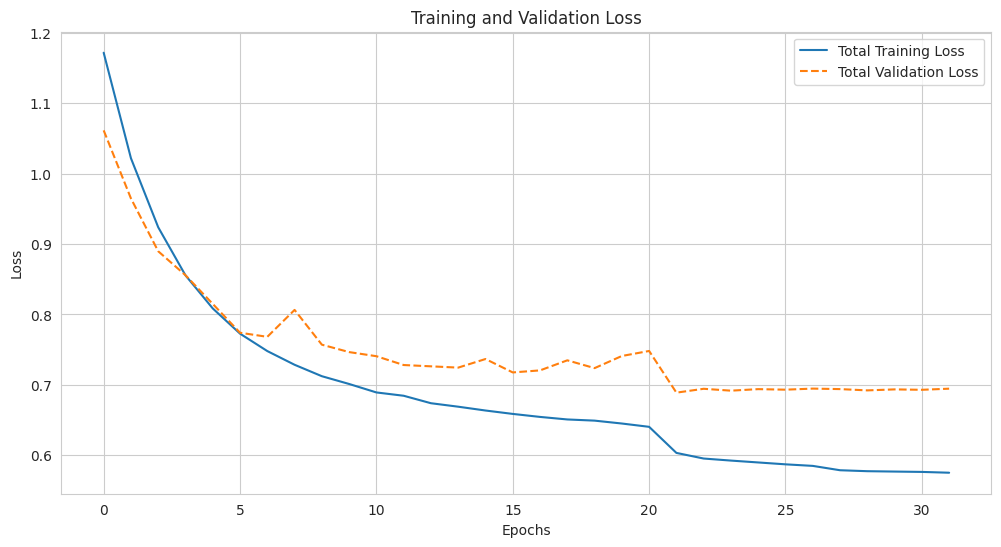

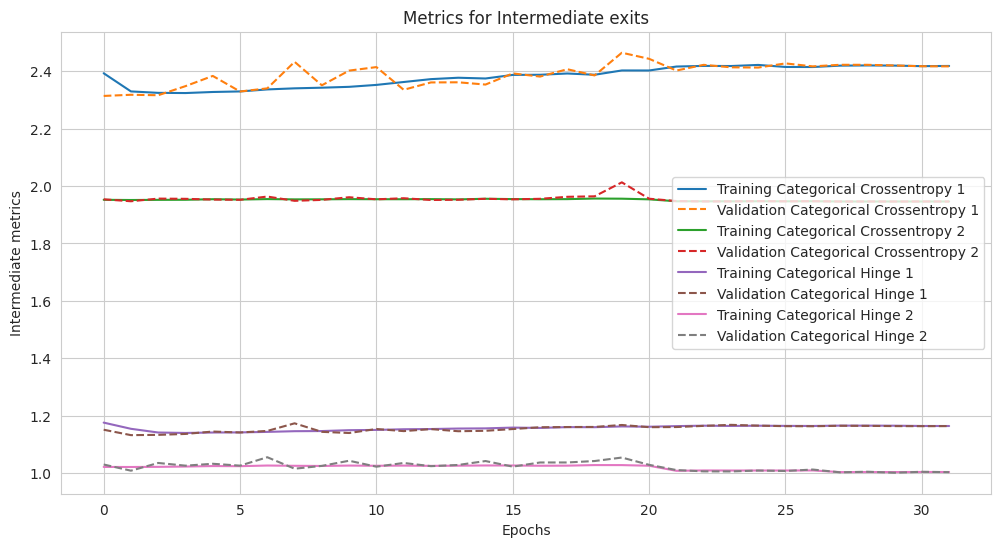

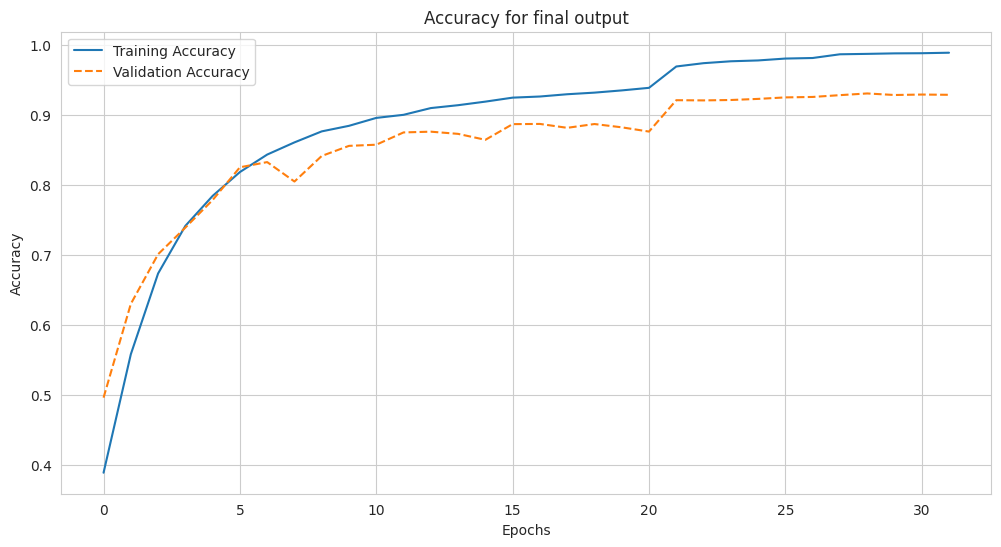

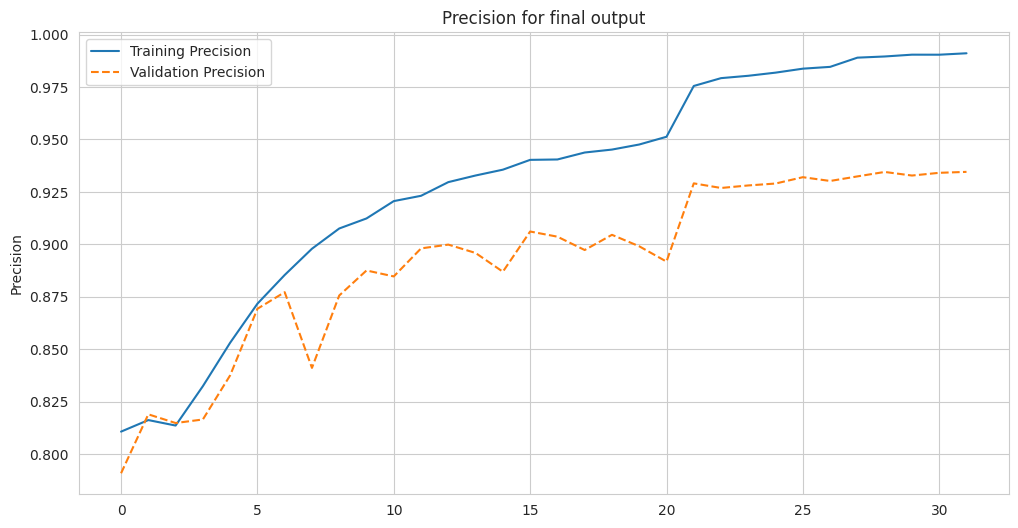

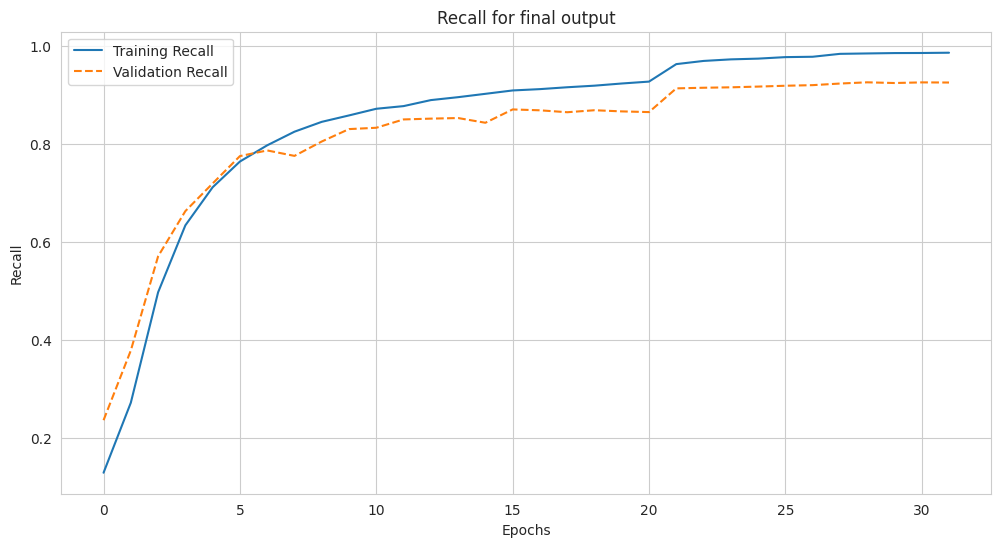

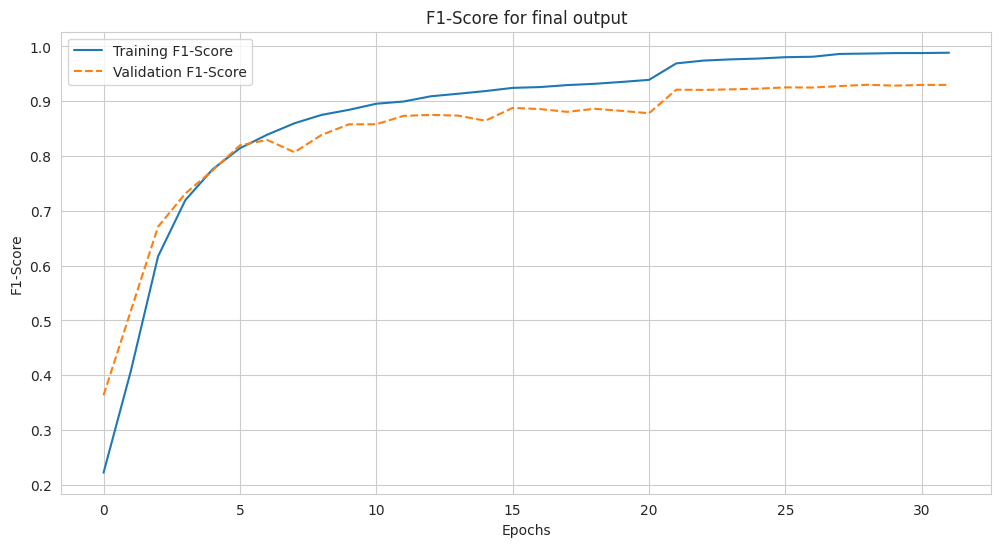

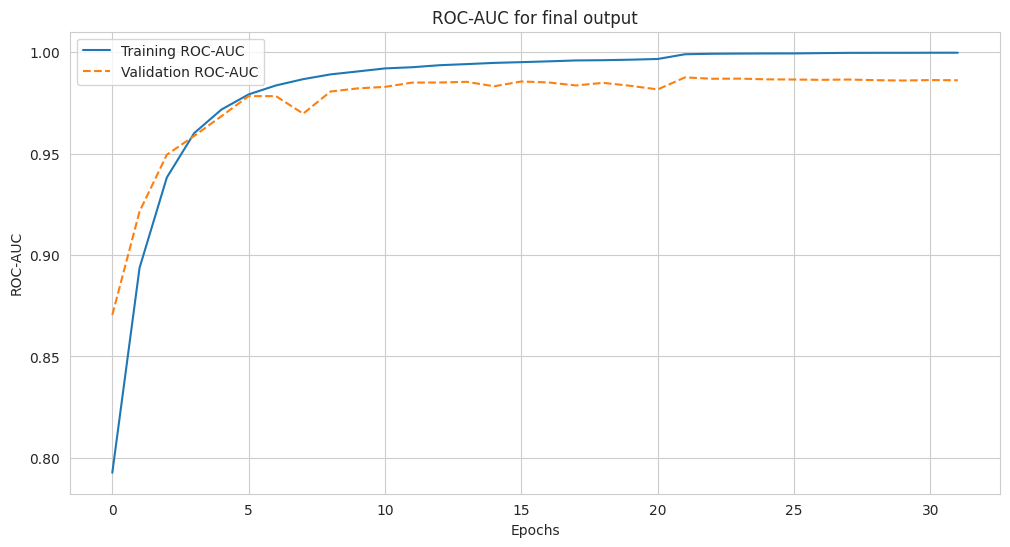

In [71]:
import matplotlib.pyplot as plt
# Extract training history
history_dict = history.history
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Total Training Loss')
plt.plot(history_dict['val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['categorical_crossentropy_1'], label='Training Categorical Crossentropy 1')
plt.plot(history_dict['val_categorical_crossentropy_1'], label='Validation Categorical Crossentropy 1', linestyle='--')
plt.plot(history_dict['categorical_crossentropy_2'], label='Training Categorical Crossentropy 2')
plt.plot(history_dict['val_categorical_crossentropy_2'], label='Validation Categorical Crossentropy 2', linestyle='--')
plt.plot(history_dict['categorical_hinge_1'], label='Training Categorical Hinge 1')
plt.plot(history_dict['val_categorical_hinge_1'], label='Validation Categorical Hinge 1', linestyle='--')
plt.plot(history_dict['categorical_hinge_2'], label='Training Categorical Hinge 2')
plt.plot(history_dict['val_categorical_hinge_2'], label='Validation Categorical Hinge 2', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Intermediate metrics')
plt.title('Metrics for Intermediate exits')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for final output')
plt.legend()
plt.grid(True)
plt.show()
# Plot Precision
plt.figure(figsize=(12, 6))
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision', linestyle='--')
plt.ylabel('Precision')
plt.title('Precision for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall
plt.figure(figsize=(12, 6))
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score
plt.figure(figsize=(12, 6))
plt.plot(history_dict['f1_score'], label='Training F1-Score')
plt.plot(history_dict['val_f1_score'], label='Validation F1-Score', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(12, 6))
plt.plot(history_dict['roc_auc'], label='Training ROC-AUC')
plt.plot(history_dict['val_roc_auc'], label='Validation ROC-AUC', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC for final output')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Evaluate the student model
evaluation_results = distillation_model.evaluate(
    x_test,  # Test inputs
    {
        'student_exit_1': y_test,  # Targets for exit 1
        'student_exit_2': y_test,  # Targets for exit 2
        'student_final_output': y_test,  # Targets for the final output
    },
    verbose=1
)

438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9222 - categorical_crossentropy_1: 2.4200 - categorical_crossentropy_2: 1.9476 - categorical_hinge_1: 1.1618 - categorical_hinge_2: 1.0103 - f1_score: 0.9229 - loss: 0.6870 - precision: 0.9301 - recall: 0.9158 - roc_auc: 0.9881


438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step


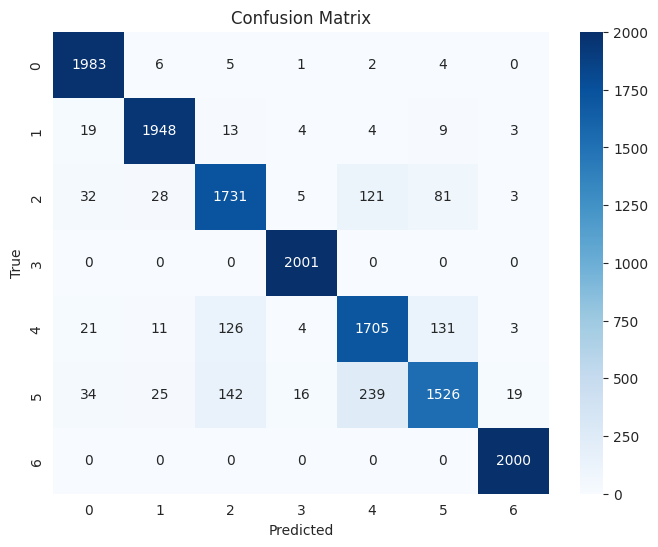

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plots the confusion matrix with a heatmap.
    Args:
        y_true: True labels of the test set.
        y_pred: Predicted labels from the model.
        class_names: List of class names (strings).
        title: Title for the plot.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
# Predict on test set
y_pred = distillation_model.predict(x_test)

# If `y_pred` is a dictionary or tuple, extract the final output
if isinstance(y_pred, dict):
    y_pred_final = y_pred['student_final_output']
elif isinstance(y_pred, (list, tuple)):
    y_pred_final = y_pred[-1]  # Assuming the final output is the last one
else:
    y_pred_final = y_pred  # Single output (unlikely for this case)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_final, axis=1)
# True labels
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
# Class names
class_names = [0, 1, 2, 3, 4, 5, 6]  
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, class_names)

In [74]:
distillation_model.save("distilled.hdf5")